# NLP Project: Fine-tuning DistilBERT for Intent Detection on CLINC150

This notebook documents the fine-tuning process of the DistilBERT transformer model for the task of intent detection using the CLINC150 dataset.

Intent detection is a core task in natural language understanding (NLU), commonly used in systems such as chatbots and virtual assistants, where the goal is to identify the user's intention behind a natural language query.

## CLINC150 Dataset

CLINC150 is a widely used benchmark consisting of 150 distinct intents drawn from real-world user queries. Its large number of fine-grained classes makes it ideal for evaluating a model's generalization capabilities.

## DistilBERT Model

DistilBERT is a compressed version of BERT designed to be smaller, faster, and more efficient, while retaining most of BERT's performance. This makes it well-suited for scenarios with limited computational resources or when inference speed is critical.

## Project Objectives

1. **Data Preparation:** Load, explore, and preprocess the CLINC150 dataset.
2. **Fine-Tuning:** Adapt DistilBERT for multi-class classification (150 intent classes).
3. **Evaluation:** Measure performance using accuracy and F1-score, with per-class analysis.
4. **Error Analysis:** Examine misclassified examples to identify model limitations.
5. **(Optional) Robustness Testing:** Explore how the model handles small input perturbations.


In [ ]:
# Install libraries (if needed)
# !pip install transformers datasets scikit-learn pandas numpy matplotlib seaborn ipywidgets tqdm
!pip install -U datasets huggingface_hub fsspec

import torch
import transformers
from transformers import (
    DistilBertForSequenceClassification,
    DistilBertTokenizerFast,
    Trainer,
    TrainingArguments
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from tqdm.notebook import tqdm
from datasets import load_dataset

# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 21.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12

## Dataset Loading and Exploration

In this section, the CLINC150 dataset is loaded using the Hugging Face `datasets` library. We use the `"plus"` configuration, which includes 150 in-scope intent classes along with out-of-scope (OOS) examples.

We extract the training, validation, and test splits, along with the full list of intent labels. The dataset is then converted into raw text and corresponding intent indices for each split. These labels are also mapped to their string representation to facilitate further analysis.

To guide the tokenization setup, we perform an exploratory analysis of sentence lengths in the training set. Specifically, we compute the maximum and average number of words per utterance. This information is useful when deciding the appropriate maximum sequence length for the model input.

Finally, we display a few sample utterances and their corresponding intent labels to provide an initial sense of the data.


In [ ]:
print("Caricamento del dataset CLINC150 ('clinc_oos', 'plus') tramite Hugging Face Datasets...")
dataset = load_dataset("clinc_oos", "plus")

print("Splits disponibili:", dataset.keys())
print("Numero di esempi nel Training Set:", len(dataset["train"]))
print("Numero di esempi nel Validation Set:", len(dataset["validation"]))
print("Numero di esempi nel Test Set:", len(dataset["test"]))

#estrae i nomi degli intenti e crea le mapping ID <-> Label
intent_names = dataset["train"].features["intent"].names
num_labels = len(intent_names)
label_to_id = {label: i for i, label in enumerate(intent_names)}
id_to_label = {i: label for i, label in enumerate(intent_names)}


print(f"\nNumero totale di intenti unici: {num_labels}")
print(f"Primi 5 intenti: {intent_names[:5]}")
print(f"Esempio dal dataset di training:\n{dataset['train'][0]}")

#estrae testi e label (convertendo gli ID numerici in stringhe per l'analisi)
train_texts = dataset["train"]["text"]
train_labels_encoded = dataset["train"]["intent"]
train_labels_str = [id_to_label[label_id] for label_id in train_labels_encoded]

val_texts = dataset["validation"]["text"] #'validation' come split di validazione
val_labels_encoded = dataset["validation"]["intent"]
val_labels_str = [id_to_label[label_id] for label_id in val_labels_encoded]

test_texts = dataset["test"]["text"]
test_labels_encoded = dataset["test"]["intent"]
test_labels_str = [id_to_label[label_id] for label_id in test_labels_encoded]

print(f"\nNumero di esempi nel Training Set: {len(train_texts)}")
print(f"Numero di esempi nel Validation Set: {len(val_texts)}")
print(f"Numero di esempi nel Test Set: {len(test_texts)}")

# --- Analisi Esplorativa dei Dati (EDA) ---

# Distribuzione delle lunghezze delle frasi
train_lengths = [len(text.split()) for text in train_texts]

print(f"\nLunghezza massima delle frasi nel Training Set: {max(train_lengths)} parole")
print(f"Lunghezza media delle frasi nel Training Set: {np.mean(train_lengths):.2f} parole")
print("Questa analisi aiuta a determinare un valore appropriato per 'max_length' per la tokenizzazione.")

# Esempi di frasi e intenti
print("\nEsempi di frasi e i loro intenti:")
for i in range(3):
    print(f"  Frase: '{train_texts[i]}'")
    print(f"  Intento: '{train_labels_str[i]}'")
    print("-" * 30)

Caricamento del dataset CLINC150 ('clinc_oos', 'plus') tramite Hugging Face Datasets...
Splits disponibili: dict_keys(['train', 'validation', 'test'])
Numero di esempi nel Training Set: 15250
Numero di esempi nel Validation Set: 3100
Numero di esempi nel Test Set: 5500

Numero totale di intenti unici: 151
Primi 5 intenti: ['restaurant_reviews', 'nutrition_info', 'account_blocked', 'oil_change_how', 'time']
Esempio dal dataset di training:
{'text': 'what expression would i use to say i love you if i were an italian', 'intent': 61}

Numero di esempi nel Training Set: 15250
Numero di esempi nel Validation Set: 3100
Numero di esempi nel Test Set: 5500

Lunghezza massima delle frasi nel Training Set: 28 parole
Lunghezza media delle frasi nel Training Set: 8.32 parole
Questa analisi aiuta a determinare un valore appropriato per 'max_length' per la tokenizzazione.

Esempi di frasi e i loro intenti:
  Frase: 'what expression would i use to say i love you if i were an italian'
  Intento: 'trans

#Pre-processing and Tokenization

In this section, we load the DistilBERT tokenizer to prepare the text data for model input. We set a maximum sequence length (commonly 64 or 128) based on prior exploratory analysis of sentence lengths, ensuring efficient processing of short chatbot utterances.

We define a custom PyTorch dataset class that handles the tokenized inputs along with their corresponding labels, ensuring the labels are correctly formatted as long tensors for compatibility with the model.

A helper function is implemented to tokenize input texts with appropriate padding and truncation, returning a PyTorch dataset ready for training or evaluation.

Finally, we apply this tokenization process to the training, validation, and test splits, creating tokenized datasets and reporting the number of examples in each.


In [ ]:
#caricamento del tokenizer di DistilBERT
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
MAX_LENGTH = 64 #lunghezza max in token

print(f"\nCaricato il tokenizer DistilBERT. Max length impostata a: {MAX_LENGTH}")

class Clinc150Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

def tokenize_and_create_dataset(texts, labels, tokenizer, max_length):
    #tokenizzazione con padding e troncamento
    encodings = tokenizer(texts, truncation=True, padding='max_length', max_length=max_length, return_tensors='pt')

    #crea dataset
    dataset = Clinc150Dataset(encodings, labels)
    return dataset

#dataset tokenizzati
train_dataset = tokenize_and_create_dataset(train_texts, train_labels_encoded, tokenizer, MAX_LENGTH)
val_dataset = tokenize_and_create_dataset(val_texts, val_labels_encoded, tokenizer, MAX_LENGTH)
test_dataset = tokenize_and_create_dataset(test_texts, test_labels_encoded, tokenizer, MAX_LENGTH)

print(f"\nDataset di training tokenizzato: {len(train_dataset)} esempi")
print(f"Dataset di validazione tokenizzato: {len(val_dataset)} esempi")
print(f"Dataset di test tokenizzato: {len(test_dataset)} esempi")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]


Caricato il tokenizer DistilBERT. Max length impostata a: 64

Dataset di training tokenizzato: 15250 esempi
Dataset di validazione tokenizzato: 3100 esempi
Dataset di test tokenizzato: 5500 esempi


#Model Definition

This section involves loading the pre-trained DistilBERT model configured for sequence classification tasks. The model is initialized with the appropriate number of output classes corresponding to the number of intent labels.

After loading, the model is moved to the designated computing device (GPU or CPU) to enable efficient training and inference.


In [ ]:
#caricamento del modello DistilBERT pre-addestrato per classificazione di sequenze
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_labels)
model.to(device) #sposta il modello sul device (GPU/CPU)

print(f"\nModello DistilBertForSequenceClassification caricato con {num_labels} classi per l'output.")
print(f"Modello spostato su: {device}")

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Modello DistilBertForSequenceClassification caricato con 151 classi per l'output.
Modello spostato su: cuda


#Fine-tuning Configuration

This section defines the evaluation metrics used during training, including weighted and macro F1-scores to address class imbalance, alongside accuracy.

We set up the training arguments for the Hugging Face Trainer, specifying parameters such as output directories, number of epochs, batch sizes for training and evaluation, learning rate warm-up steps, weight decay for regularization, logging configuration, evaluation and checkpoint saving strategies, and criteria for selecting the best model.

The configuration ensures the model saves and loads the best-performing checkpoint based on the weighted F1 score, while limiting saved checkpoints and disabling external reporting services.

In [ ]:
#metriche di valutazione
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    #calcola F1-score con 'weighted' e 'macro' per tenere conto dello sbilanciamento e dare pari peso
    f1_weighted = f1_score(labels, preds, average='weighted')
    f1_macro = f1_score(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)

    #restituisce il dizionario con le metriche
    return {'accuracy': acc, 'f1_weighted': f1_weighted, 'f1_macro': f1_macro}

training_args = TrainingArguments(
    output_dir='./results',          #directory checkpoint
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,               #per la regolarizzazione
    logging_dir='./logs',
    logging_steps=100,
    eval_strategy="epoch",           #valuta le performance sul validation set alla fine di ogni epoca
    save_strategy="epoch",
    load_best_model_at_end=True,     #carica il modello con le migliori performance (sul validation set) alla fine del training
    metric_for_best_model="f1_weighted", #per determinare il "miglior" modello
    report_to="none",
    save_total_limit=1,
)

print("\nConfigurazione di TrainingArguments completata.")


Configurazione di TrainingArguments completata.


#Training Phase (Fine-tuning)

In this phase, the Hugging Face Trainer is initialized with the model, training arguments, datasets, and evaluation metrics.

The fine-tuning process is started, and upon completion, training logs are extracted for analysis.

Two plots are generated: one showing the progression of training and validation loss over training steps, and another displaying validation accuracy and weighted F1-score metrics.

These visualizations provide insights into the model’s learning behavior and performance on the validation set throughout training.



Avvio del fine-tuning del modello...


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,F1 Macro
1,0.766000,0.547888,0.900968,0.894929,0.899486
2,0.141400,0.270253,0.939032,0.937784,0.943274
3,0.048300,0.262896,0.946452,0.945960,0.949291
4,0.013400,0.275292,0.949032,0.948139,0.953044
5,0.003600,0.274719,0.948065,0.947391,0.951933
6,0.005500,0.300410,0.947419,0.946529,0.950844
7,0.009400,0.289879,0.948387,0.947139,0.951925
8,0.001600,0.299098,0.951613,0.950735,0.955040
9,0.001100,0.297252,0.951935,0.951188,0.955439
10,0.003300,0.298245,0.953548,0.952739,0.956846



Fine-tuning completato!


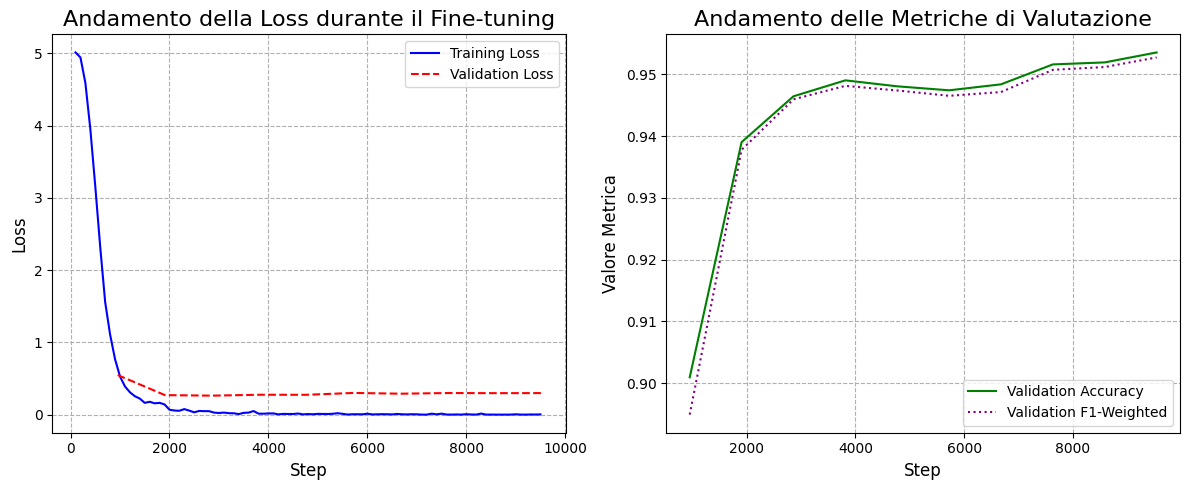


I grafici mostrano l'andamento della loss e delle metriche sul set di validazione durante il training.


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

print("\nAvvio del fine-tuning del modello...")
#avvio del training
trainer.train()

print("\nFine-tuning completato!")

log_history = pd.DataFrame(trainer.state.log_history)

#plot della Loss (Training vs. Validation)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
#filtra per la loss del training (colonna 'loss')
train_loss_data = log_history[log_history['loss'].notna()]
plt.plot(train_loss_data['step'], train_loss_data['loss'], label='Training Loss', color='blue')
#filtra per la loss di valutazione (colonna 'eval_loss')
eval_loss_data = log_history[log_history['eval_loss'].notna()]
plt.plot(eval_loss_data['step'], eval_loss_data['eval_loss'], label='Validation Loss', color='red', linestyle='--')
plt.title('Andamento della Loss durante il Fine-tuning', fontsize=16)
plt.xlabel('Step', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--')

#plot delle Metriche di Valutazione (Accuracy e F1-weighted)
plt.subplot(1, 2, 2)
#filtra per le metriche di valutazione
eval_metrics_data = log_history[log_history['eval_accuracy'].notna()]
plt.plot(eval_metrics_data['step'], eval_metrics_data['eval_accuracy'], label='Validation Accuracy', color='green')
plt.plot(eval_metrics_data['step'], eval_metrics_data['eval_f1_weighted'], label='Validation F1-Weighted', color='purple', linestyle=':')
plt.title('Andamento delle Metriche di Valutazione', fontsize=16)
plt.xlabel('Step', fontsize=12)
plt.ylabel('Valore Metrica', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--')

plt.tight_layout()
plt.show()

print("\nI grafici mostrano l'andamento della loss e delle metriche sul set di validazione durante il training.")

#Final Evaluation on the Test Set

This section performs the final evaluation of the fine-tuned model on the test dataset.

Predictions are generated for the test inputs, and the predicted class indices are extracted alongside the true labels.

Overall performance metrics, including accuracy, weighted F1-score, and macro F1-score, are calculated and displayed to summarize model effectiveness.

Additionally, a detailed classification report is produced, showing precision, recall, F1-score, and support for each individual intent class, providing a comprehensive view of the model’s performance across all classes.


In [ ]:
print("\nAvvio della valutazione finale sul Test Set...")

#esegue le predizioni sul test set
predictions_output = trainer.predict(test_dataset)

#estrae le predizioni (gli indici della classe con la probabilità più alta) e le label vere
test_preds = predictions_output.predictions.argmax(-1)
test_labels = predictions_output.label_ids

print("\n--- Risultati Complessivi sul Test Set ---")
#calcola e stampa le metriche globali
final_accuracy = accuracy_score(test_labels, test_preds)
final_f1_weighted = f1_score(test_labels, test_preds, average='weighted')
final_f1_macro = f1_score(test_labels, test_preds, average='macro')

print(f"Accuracy finale sul Test Set: {final_accuracy:.4f}")
print(f"F1-score (Weighted) finale sul Test Set: {final_f1_weighted:.4f}")
print(f"F1-score (Macro) finale sul Test Set: {final_f1_macro:.4f}")

print("\n--- Classification Report per Classe ---")
#genera il classification report dettagliato che mostra precision, recall, f1-score e support per ogni singola classe
print(classification_report(test_labels, test_preds, target_names=intent_names, zero_division=0))


Avvio della valutazione finale sul Test Set...



--- Risultati Complessivi sul Test Set ---
Accuracy finale sul Test Set: 0.8785
F1-score (Weighted) finale sul Test Set: 0.8715
F1-score (Macro) finale sul Test Set: 0.9110

--- Classification Report per Classe ---
                           precision    recall  f1-score   support

       restaurant_reviews       0.79      0.87      0.83        30
           nutrition_info       0.88      1.00      0.94        30
          account_blocked       0.82      0.93      0.88        30
           oil_change_how       0.81      1.00      0.90        30
                     time       0.91      0.97      0.94        30
                  weather       0.67      1.00      0.80        30
           redeem_rewards       1.00      0.80      0.89        30
            interest_rate       0.85      0.97      0.91        30
                 gas_type       0.94      1.00      0.97        30
      accept_reservations       0.87      0.90      0.89        30
               smart_home       0.71      0.97

#Error Analysis

In this section, we analyze examples from the test set that the model misclassified.

A DataFrame is created to align each test utterance with its true and predicted labels, both as numeric IDs and human-readable strings.

We filter for instances where the predicted intent differs from the true intent and report the total number of such errors.

If misclassifications exist, a sample of up to 10 examples is displayed, showing the utterance along with its true and predicted intents to provide insight into common error patterns.

This error analysis helps identify model weaknesses and potential semantic overlaps between intent classes.


In [ ]:
print("\n--- Analisi di Esempi Classificati Erroneamente ---")

#crea un DataFrame per facilitare l'analisi degli errori
results_df = pd.DataFrame({
    'text': test_texts,
    'true_label_id': test_labels,
    'predicted_label_id': test_preds
})

results_df['true_label'] = results_df['true_label_id'].apply(lambda x: id_to_label[x])
results_df['predicted_label'] = results_df['predicted_label_id'].apply(lambda x: id_to_label[x])

#filtra solo gli errori
misclassified_examples = results_df[results_df['true_label'] != results_df['predicted_label']]

print(f"Numero totale di esempi classificati erroneamente: {len(misclassified_examples)}")

if not misclassified_examples.empty:
    print("\nEcco alcuni esempi di classificazioni errate:")
    #mostra un campione di errori
    sample_errors = misclassified_examples.sample(min(10, len(misclassified_examples)), random_state=42)

    for index, row in sample_errors.iterrows():
        print(f"  Frase: '{row['text']}'")
        print(f"  Intento Vero: {row['true_label']}")
        print(f"  Intento Predetto: {row['predicted_label']}")
        print("-" * 50)
else:
    print("Nessun errore di classificazione trovato (o dataset troppo piccolo per mostrare campioni).")

print("\nAnalizzare questi errori aiuta a capire le debolezze del modello e le somiglianze tra intenti.")


--- Analisi di Esempi Classificati Erroneamente ---
Numero totale di esempi classificati erroneamente: 668

Ecco alcuni esempi di classificazioni errate:
  Frase: 'what is harry's real name'
  Intento Vero: oos
  Intento Predetto: are_you_a_bot
--------------------------------------------------
  Frase: 'tell jim i'm coming home soon'
  Intento Vero: text
  Intento Predetto: make_call
--------------------------------------------------
  Frase: 'find out where i can by melamine dinner plates'
  Intento Vero: oos
  Intento Predetto: restaurant_suggestion
--------------------------------------------------
  Frase: 'compare prices of malt-o-meal to kelloggs'
  Intento Vero: oos
  Intento Predetto: calories
--------------------------------------------------
  Frase: 'what stores are at my local mall'
  Intento Vero: oos
  Intento Predetto: shopping_list
--------------------------------------------------
  Frase: 'where's the best place to hike in the rockies'
  Intento Vero: oos
  Intento 

#Conclusion and Future Work

This work demonstrated the fine-tuning of a transformer-based model, specifically DistilBERT, for intent detection across a diverse set of user queries. The results confirm that lightweight pretrained language models can deliver strong performance in natural language understanding tasks with minimal architectural changes.

The training and evaluation pipeline proved efficient and effective, with the model generalizing well on unseen test data. This highlights the value of leveraging pretrained transformers for classification problems.

Future work could explore applying the approach to other datasets to assess adaptability and robustness. Comparing different model architectures or experimenting with training hyperparameters like epochs and dataset size may also provide valuable insights.

Additionally, integrating the model into real-world systems such as chatbots or voice assistants would allow evaluation of its performance in interactive, dynamic scenarios.

These extensions would help clarify the model’s strengths and weaknesses and guide improvements for future iterations.
